# Object-Scene Scaling Analysis

In [343]:
import numpy as np
import os
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.stats import sem


### Exclusion Criteria
 - Accuracy: 70 % (17/24 correct)
 - RT: Exclude trial if < 250 ms or > 2s
 - Remove participant if more than 10% of the data is removed (?) 
    

### Pilot Analysis Plots

1. Overall Accuracy
    - accuracy by scene category
    - accuracy by zoom 
    - accuracy by zoom x match
2. RT Distribution
    - RT by scene category
    - RT by zoom 
    - RT by zoom x match
3. 2x3 ANOVA
 

In [344]:
def combineCSVs(datafolder):
    """
    Combine all participant data into one pandas df
    OR 
    Create df for single participant file 
    """
    
    exclude = []
    
    #checks if path is a file
    isFile = os.path.isfile(datafolder)

    #checks if path is a directory
    
    isDirectory = os.path.isdir(datafolder)
    
    if isDirectory == True:
        data = []
        for filename in os.listdir(datafolder):
            if 'csv' in filename:
                path = datafolder + "/" + filename
                df = pd.read_csv(path, index_col=None, header=0)
                
                # do NOT include subject IDs that have been flagged 
                subjID = df.subjID.unique()[0]
                if subjID not in exclude:
                    data.append(df)

                
        input_frame = pd.concat(data, axis=0, ignore_index=True)
        
    if isFile == True:
        if 'csv' in datafolder:
            input_frame = pd.read_csv(datafolder, index_col=None, header=0)
    
    print('Number of participants before cleaning: ', len(input_frame.subjID.unique()))

 
    return input_frame

In [345]:
# data_path = '/Users/prachi/Documents/object_scene_scaling_data/pilot2'

data_path = '/Users/prachimahableshwarkar/Documents/GW/FacialAge/FacialAge_MTurk/OSS_MTurk/data'

In [346]:
input_data = combineCSVs(data_path)

Number of participants before cleaning:  40


In [347]:
# input_data

In [325]:
num_trials = 24

In [348]:
def cleanbyPracticeTries(df, num_allowed_tries):
    all_subjIDs = df.subjID.unique()
    
    remove = []
    df2_list = []
    for subj in all_subjIDs:
        count = 0
        subj_df = df.loc[df['subjID'] == subj]
        cleaned_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 
        
        subj_num_practice_tries = cleaned_subj_df.pracTries.unique()[0]
        
        if subj_num_practice_tries > num_allowed_tries:
            remove.append(subj)
        else:  
            df2_list.append(cleaned_subj_df)
    
    df2 = pd.concat(df2_list)
            
    print('Number of participants with more than ' + str(num_allowed_tries) + ' practice tries:', len(remove))
    
    return df2
    

In [349]:
pracTries_cleaned_data = cleanbyPracticeTries(input_data, 3)

Number of participants with more than 3 practice tries: 13


In [350]:
len(pracTries_cleaned_data.subjID.unique())

27

In [351]:
def RT_Cleaning(df, outlier_range, num_trials):
    """
    Remove trials where trial RT is outside of the defined outlier range 
    
    Returns:
        dataframe with outlier RT trials removed
        list of all RTs 
    """
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    print(len(all_subjIDs))
    
    remove = []
    df2_list = []
    total_RT_outliers = 0
    total = 0
    list_trialRT = []
    for subj in all_subjIDs:
        count = 0
        subj_df = df.loc[df['subjID'] == subj]
        cleaned_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 

        for idx, row in subj_df.iterrows():
            total += 1
            RT = row["RT"]
            list_trialRT.append(RT)
            if RT < outlier_range[0]: # outlier
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
                total_RT_outliers += 1
            if RT > outlier_range[1]:
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
                total_RT_outliers += 1
        
        df2_list.append(cleaned_subj_df)
    
    df2 = pd.concat(df2_list)
    print(len(df2.subjID.unique()))
                
    return df2, list_trialRT

In [352]:
RT_cleaned_data, trialRTs_distribution = RT_Cleaning(pracTries_cleaned_data, [250, 2000], num_trials)


27
26


In [353]:
len(RT_cleaned_data.subjID.unique())

26

In [354]:
pracTries_cleaned_data.subjID.unique(), RT_cleaned_data.subjID.unique()

(array([528839, 496233, 211110, 383309, 248078, 328097, 495102, 506048,
        386113, 419878, 194402, 606823, 721269, 923981, 167158, 366278,
        365212, 464832, 950715, 106588, 307437, 825101, 508126, 309560,
        192539, 549001, 140938]),
 array([528839, 496233, 211110, 383309, 248078, 328097, 495102, 506048,
        386113, 419878, 194402, 606823, 721269, 923981, 167158, 366278,
        365212, 464832, 950715, 106588, 307437, 825101, 508126, 309560,
        192539, 549001]))

In [355]:
def Accuracy_Cleaning(df, accuracy_threshold, num_trials):
    """    
    Remove participants with overall accuracy below the accuracy threshold (e.g. 0.7)
    
    Returns:
        data of participants that passed the accuracy threshold 
        list of the number of correct trials each participant got
    """
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    remove = []
    df2_list = []
    list_trials_correct = []
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        cleaned_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 
        
        subj_num_correct_trials = 0
        for idx, row in subj_df.iterrows():
            trial_acc = row['accuracy']
            if trial_acc == 1:
                subj_num_correct_trials += 1
                
        subj_acc = subj_num_correct_trials/num_trials
                
        # minimum number of trials correct the participant must have to be included
        if subj_acc < accuracy_threshold:
            remove.append(subj)
        
        list_trials_correct.append(subj_num_correct_trials)
        
        df2_list.append(cleaned_subj_df)
    
    df2 = pd.concat(df2_list)
    
    print("Number of Participants with accuracy below 70%: ", len(remove))
    
    for index, row in df2.iterrows():
        if row['subjID'] in remove:
            df2.drop(index, inplace=True)
            
    print(len(df2.subjID.unique()))
                
    return df2, list_trials_correct 

In [356]:
Accuracy_cleaned_data, correct_trials_distribution = Accuracy_Cleaning(RT_cleaned_data, 0.7, num_trials)


Number of Participants with accuracy below 70%:  19
7


In [357]:
len(Accuracy_cleaned_data.subjID.unique())

7

In [358]:
np.sum(np.array(Accuracy_cleaned_data['accuracy']))/len(np.array(Accuracy_cleaned_data['accuracy']))

0.8373493975903614

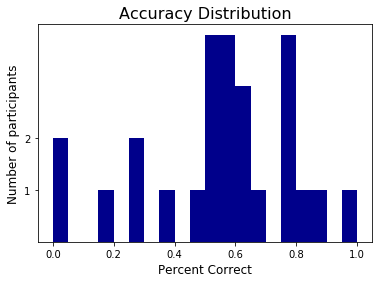

In [359]:
plt.figure()
plt.hist((np.array(correct_trials_distribution))/num_trials, color='darkblue', bins=20)
plt.yticks(np.arange(1,3))
plt.title('Accuracy Distribution', fontsize=16)
plt.xlabel('Percent Correct', fontsize=12)
plt.ylabel('Number of participants', fontsize=12)
plt.show()

In [360]:
final_data = Accuracy_cleaned_data.copy(deep=True)
len(Accuracy_cleaned_data.subjID.unique())

7

In [361]:
# data split by semantic match
catCongruent_df = final_data.loc[final_data['semanticMatch'] == 1.0]
catIncongruent_df = final_data.loc[final_data['semanticMatch'] == 0.0]


In [362]:
# data split by zoom level 
zo_df = final_data.loc[final_data['sceneZoom'] == 'zo']
zi_df = final_data.loc[final_data['sceneZoom'] == 'zi']
zc_df = final_data.loc[final_data['sceneZoom'] == 'zc']


In [363]:
# semantic matched data across all zooms 
zo_catCongruent = catCongruent_df.loc[catCongruent_df['sceneZoom'] == 'zo']
zi_catCongruent = catCongruent_df.loc[catCongruent_df['sceneZoom'] == 'zi']
zc_catCongruent = catCongruent_df.loc[catCongruent_df['sceneZoom'] == 'zc']


In [364]:
# semantic mis-matched data across all zooms 
zo_catIncongruent = catIncongruent_df.loc[catIncongruent_df['sceneZoom'] == 'zo']
zi_catIncongruent = catIncongruent_df.loc[catIncongruent_df['sceneZoom'] == 'zi']
zc_catIncongruent = catIncongruent_df.loc[catIncongruent_df['sceneZoom'] == 'zc']


## Accuracy


add error bars
- overall accuracy per subj in each condition 

In [365]:
catCongruent_acc = np.sum(np.array(catCongruent_df['accuracy']))/len(np.array(catCongruent_df['accuracy']))
catIncongruent_acc = np.sum(np.array(catIncongruent_df['accuracy']))/len(np.array(catIncongruent_df['accuracy']))

catCongruent_acc, catIncongruent_acc

(0.8690476190476191, 0.8048780487804879)

In [366]:
zo_acc = np.sum(np.array(zo_df['accuracy']))/len(np.array(zo_df['accuracy']))
zi_acc = np.sum(np.array(zi_df['accuracy']))/len(np.array(zi_df['accuracy']))
zc_acc = np.sum(np.array(zc_df['accuracy']))/len(np.array(zc_df['accuracy']))

zo_acc, zc_acc, zi_acc

(0.8545454545454545, 0.8181818181818182, 0.8392857142857143)

In [367]:
zo_catCongruent_acc = np.sum(np.array(zo_catCongruent['accuracy']))/len(np.array(zo_catCongruent['accuracy']))
zi_catCongruent_acc = np.sum(np.array(zi_catCongruent['accuracy']))/len(np.array(zi_catCongruent['accuracy']))
zc_catCongruent_acc = np.sum(np.array(zc_catCongruent['accuracy']))/len(np.array(zc_catCongruent['accuracy']))

zo_catCongruent_acc,  zc_catCongruent_acc, zi_catCongruent_acc

(0.8571428571428571, 0.8928571428571429, 0.8571428571428571)

In [368]:
zo_catCongruent_acc_sem = sem(np.array(zo_catCongruent['accuracy']))/len(np.array(zo_catCongruent['accuracy']))
zi_catCongruent_acc_sem = sem(np.array(zi_catCongruent['accuracy']))/len(np.array(zi_catCongruent['accuracy']))
zc_catCongruent_acc_sem = sem(np.array(zc_catCongruent['accuracy']))/len(np.array(zc_catCongruent['accuracy']))



In [369]:
zo_catIncongruent_acc = np.sum(np.array(zo_catIncongruent['accuracy']))/len(np.array(zo_catIncongruent['accuracy']))
zi_catIncongruent_acc = np.sum(np.array(zi_catIncongruent['accuracy']))/len(np.array(zi_catIncongruent['accuracy']))
zc_catIncongruent_acc = np.sum(np.array(zc_catIncongruent['accuracy']))/len(np.array(zc_catIncongruent['accuracy']))

zo_catIncongruent_acc, zc_catIncongruent_acc ,zi_catIncongruent_acc

(0.8518518518518519, 0.7407407407407407, 0.8214285714285714)

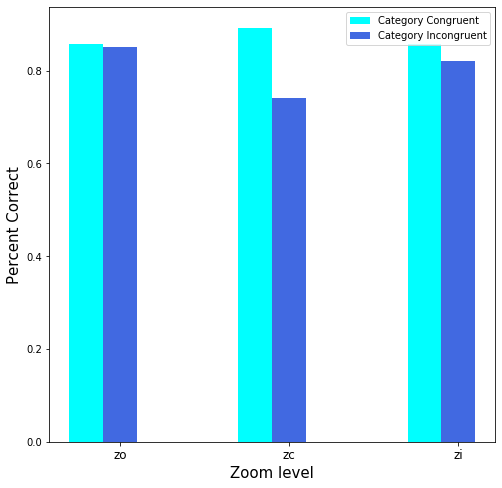

In [370]:
plt.figure(figsize=[8,8])
x = np.arange(3)
#                          z0                   zc                  zi
Acc_catCongruent =   [zo_catCongruent_acc, zc_catCongruent_acc, zi_catCongruent_acc]

Acc_catIncongruent = [zo_catIncongruent_acc, zc_catIncongruent_acc, zi_catIncongruent_acc]

width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, Acc_catCongruent, width, color='cyan', label='Category Congruent')
plt.bar(x, Acc_catIncongruent, width, color='royalblue', label='Category Incongruent')
plt.xticks(x, ['zo', 'zc', 'zi'], fontsize='12')
plt.xlabel("Zoom level", fontsize=15)
plt.ylabel("Percent Correct", fontsize=15)
plt.legend(loc=1, fontsize=10)
plt.show()

### Accuracy by Scene Category

In [257]:
all_sceneCategories = final_data.sceneCategory.unique()
all_sceneCategories = [scene for scene in all_sceneCategories if type(scene) == str]
all_sceneCategories

['bathroom', 'gym', 'classroom', 'kitchen']

In [258]:
scenes = []
scenes_acc = []
for scene in all_sceneCategories:
    scene_df = final_data.loc[final_data['sceneCategory'] == scene]
    scene_acc = np.sum(np.array(scene_df['accuracy']))/len(np.array(scene_df['accuracy']))
    scenes.append(scene)
    scenes_acc.append(scene_acc)


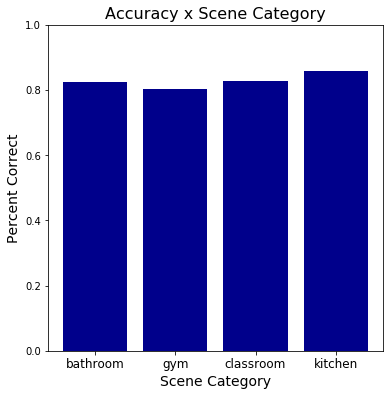

In [278]:
plt.figure(figsize=[6,6])

width = 0.2

plt.xticks(np.arange(len(scenes)), scenes, fontsize=12)
plt.ylim([0, 1])
plt.bar(np.arange(len(scenes)), scenes_acc, color='darkblue')
plt.xlabel('Scene Category', fontsize=14)
plt.ylabel('Percent Correct', fontsize=14)
plt.title('Accuracy x Scene Category', fontsize=16)

plt.show();

## RT

CREATE DIFF DF - ONLY INCLUDE CORRECT TRIALS

WITHIN PARTICIPANT SEM

In [260]:
catCongruent_df_correctOnly = catCongruent_df.loc[catCongruent_df['accuracy'] == 1]
catIncongruent_df_correctOnly = catIncongruent_df.loc[catIncongruent_df['accuracy'] == 1]

catCongruent_RT_correctOnly = np.mean(np.array(catCongruent_df_correctOnly['RT']))
catIncongruent_RT_correctOnly = np.mean(np.array(catIncongruent_df_correctOnly['RT']))

In [261]:
RTs_correctOnly = list(catCongruent_df_correctOnly['RT']) + list(catIncongruent_df_correctOnly['RT'])

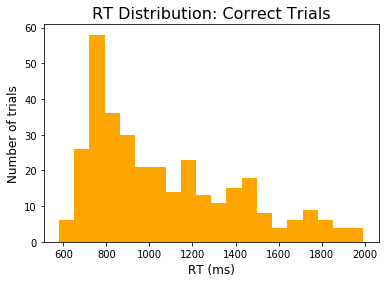

In [262]:
plt.figure()
plt.hist(np.array(RTs_correctOnly), color='orange', bins=20)
plt.title('RT Distribution: Correct Trials', fontsize=16)
plt.xlabel('RT (ms)', fontsize=12)
plt.ylabel('Number of trials', fontsize=12)
plt.show()

In [284]:
catCongruent_RT = np.mean(np.array(catCongruent_df_correctOnly['RT']))
catIncongruent_RT = np.mean(np.array(catIncongruent_df_correctOnly['RT']))

catCongruent_RT, catIncongruent_RT 



(1041.4624277456646, 1099.30625)

In [285]:
zo_df_correctOnly = zo_df.loc[zo_df['accuracy'] == 1]
zi_df_correctOnly = zi_df.loc[zi_df['accuracy'] == 1]
zc_df_correctOnly = zc_df.loc[zc_df['accuracy'] == 1]

zo_RT_correctOnly = np.mean(np.array(zo_df_correctOnly['RT']))
zi_RT_correctOnly = np.mean(np.array(zi_df_correctOnly['RT']))
zc_RT_correctOnly = np.mean(np.array(zc_df_correctOnly['RT']))

In [301]:
zo_RT_correctOnly, zc_RT_correctOnly, zi_RT_correctOnly

(1050.1565217391305, 1054.5619047619048, 1102.345132743363)

In [300]:
# zo_RT = np.mean(np.array(zo_df['RT']))
# zi_RT = np.mean(np.array(zi_df['RT']))
# zc_RT = np.mean(np.array(zc_df['RT']))

# zo_RT,  zc_RT, zi_RT,

In [287]:
zo_catCongruent_correctOnly = zo_catCongruent.loc[zo_catCongruent['accuracy'] == 1]
zi_catCongruent_correctOnly = zi_catCongruent.loc[zi_catCongruent['accuracy'] == 1]
zc_catCongruent_correctOnly = zc_catCongruent.loc[zc_catCongruent['accuracy'] == 1]

zo_catCongruent_RT_correctOnly = np.mean(np.array(zo_catCongruent_correctOnly['RT']))
zi_catCongruent_RT_correctOnly = np.mean(np.array(zi_catCongruent_correctOnly['RT']))
zc_catCongruent_RT_correctOnly = np.mean(np.array(zc_catCongruent_correctOnly['RT']))

In [291]:
zo_catCongruent_RT_correctOnly, zi_catCongruent_RT_correctOnly, zc_catCongruent_RT_correctOnly

(1031.7333333333333, 1084.0714285714287, 1009.8421052631579)

In [292]:
zo_catCongruent_RT_sem_correctOnly = sem(np.array(zo_catCongruent_correctOnly['RT']))
zi_catCongruent_RT_sem_correctOnly = sem(np.array(zi_catCongruent_correctOnly['RT']))
zc_catCongruent_RT_sem_correctOnly = sem(np.array(zc_catCongruent_correctOnly['RT']))

In [270]:
zo_catIncongruent_correctOnly = zo_catIncongruent.loc[zo_catIncongruent['accuracy']==1]
zi_catIncongruent_correctOnly = zi_catIncongruent.loc[zi_catIncongruent['accuracy']==1]
zc_catIncongruent_correctOnly = zc_catIncongruent.loc[zc_catIncongruent['accuracy']==1]


zo_catIncongruent_RT_correctOnly = np.mean(np.array(zo_catIncongruent_correctOnly['RT']))
zi_catIncongruent_RT_correctOnly = np.mean(np.array(zi_catIncongruent_correctOnly['RT']))
zc_catIncongruent_RT_correctOnly = np.mean(np.array(zc_catIncongruent_correctOnly['RT']))

In [293]:
zo_catIncongruent_RT_correctOnly, zi_catIncongruent_RT_correctOnly, zc_catIncongruent_RT_correctOnly

(1070.2545454545455, 1120.298245614035, 1107.6666666666667)

In [272]:
zo_catIncongruent_RT_sem_correctOnly = sem(np.array(zo_catIncongruent_correctOnly['RT']))
zi_catIncongruent_RT_sem_correctOnly = sem(np.array(zi_catIncongruent_correctOnly['RT']))
zc_catIncongruent_RT_sem_correctOnly = sem(np.array(zc_catIncongruent_correctOnly['RT']))


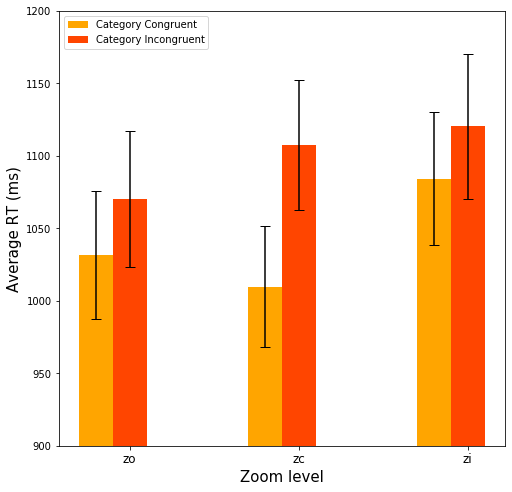

In [299]:
plt.figure(figsize=[8,8])
x = np.arange(3)

#                          z0                   zc                  zi
RT_catCongruent =   [zo_catCongruent_RT_correctOnly, zc_catCongruent_RT_correctOnly, zi_catCongruent_RT_correctOnly]
RT_catCongruent_sem = [zo_catCongruent_RT_sem_correctOnly, zc_catCongruent_RT_sem_correctOnly, zi_catCongruent_RT_sem_correctOnly]
#                          z0                   zc                  zi

RT_catIncongruent = [zo_catIncongruent_RT_correctOnly, zc_catIncongruent_RT_correctOnly, zi_catIncongruent_RT_correctOnly]
RT_catIncongruent_sem = [zo_catIncongruent_RT_sem_correctOnly, zc_catIncongruent_RT_sem_correctOnly, zi_catIncongruent_RT_sem_correctOnly]

width = 0.2

plt.ylim(900,1200)
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, RT_catCongruent, width, color='orange', label='Category Congruent', yerr=RT_catCongruent_sem, capsize=5)
plt.bar(x, RT_catIncongruent, width, color='orangered', label='Category Incongruent', yerr=RT_catIncongruent_sem, capsize=5)
plt.xticks(x, ['zo', 'zc', 'zi'], fontsize='12')
plt.xlabel("Zoom level", fontsize=15)
plt.ylabel("Average RT (ms)", fontsize=15)
plt.legend(loc=2, fontsize=10)
plt.show()

In [275]:
all_sceneCategories = final_data.sceneCategory.unique()
all_sceneCategories = [scene for scene in all_sceneCategories if type(scene) == str]
all_sceneCategories

['bathroom', 'gym', 'classroom', 'kitchen']

In [276]:
scenes = []
scenes_RT = []
scenes_sem = []
for scene in all_sceneCategories:
    scene_df = final_data.loc[final_data['sceneCategory'] == scene]
    scene_RT = np.mean(np.array(scene_df['RT']))
    scene_sem = sem(np.array(scene_df['RT']))
    scenes.append(scene)
    scenes_RT.append(scene_RT)
    scenes_sem.append(scene_sem)


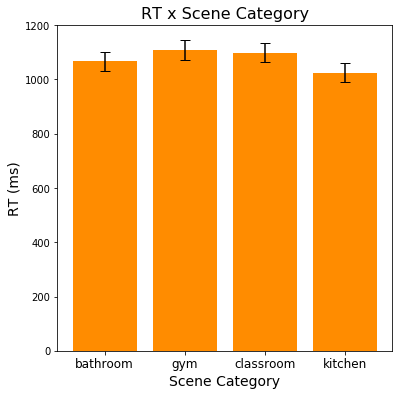

In [302]:
plt.figure(figsize=[6,6])

width = 0.2

plt.xticks(np.arange(len(scenes)), scenes, fontsize=12)
plt.bar(np.arange(len(scenes)), scenes_RT, color='darkorange', yerr = scenes_sem, capsize=5)
plt.xlabel('Scene Category', fontsize=14)
plt.ylabel('RT (ms)', fontsize=14)
plt.title('RT x Scene Category', fontsize=16)

plt.show();

## IES: Inverse Efficiency Score

RT for correct trials only or all?


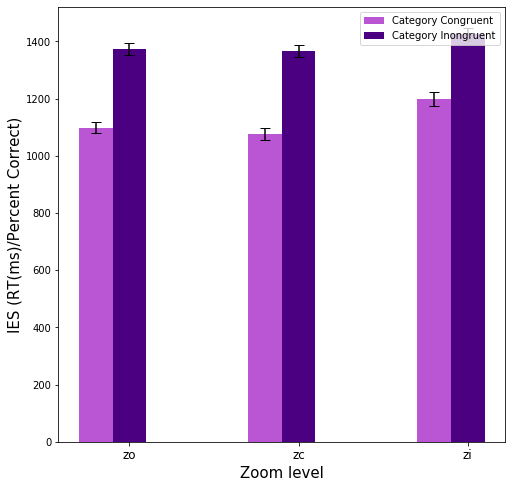

In [165]:
plt.figure(figsize=[8,8])
x = np.arange(3)

#                          z0                   zc                  zi
IES_catCongruent =   [zo_catCongruent_RT/zo_catCongruent_acc, zc_catCongruent_RT/zc_catCongruent_acc, zi_catCongruent_RT/zi_catCongruent_acc]
#                          z0                   zc                  zi

IES_catIncongruent = [zo_catIncongruent_RT/zo_catIncongruent_acc, zc_catIncongruent_RT/zc_catIncongruent_acc, zi_catIncongruent_RT/zi_catIncongruent_acc]

width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, IES_catCongruent, width, color='mediumorchid', label='Category Congruent', yerr=RT_catCongruent_sem, capsize=5)
plt.bar(x, IES_catIncongruent, width, color='indigo', label='Category Inongruent', yerr=RT_catIncongruent_sem, capsize=5)
plt.xticks(x, ['zo', 'zc', 'zi'], fontsize='12')
plt.xlabel("Zoom level", fontsize=15)
plt.ylabel("IES (RT(ms)/Percent Correct)", fontsize=15)
plt.legend(loc=1, fontsize=10)
plt.show()